In [1]:
import pandas as pd
import numpy as np
import ast
from IPython.display import display

In [2]:
df = pd.read_csv('iot-sentinel-8192-unbalanced-unbalanced.txt', sep=';')

In [35]:
max_acc = max(df['Source Accuracy'])
user_thres = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# user_thres = list(np.linspace(0,1,1001))
src_thres = [max_acc * (1-x) for x in user_thres]
src_thres, user_thres

([0.7066260354112126,
  0.7059194093758014,
  0.704506157304979,
  0.6995597750571004,
  0.6854272543488762,
  0.6359634318700914,
  0.5653008283289701,
  0.4946382247878488,
  0.42397562124672755,
  0.3533130177056063,
  0.28265041416448505,
  0.2119878106233638,
  0.1413252070822425,
  0.07066260354112125,
  0.0],
 [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [12]:
df.loc[df['Source Accuracy'].idxmax()]

Features              [0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
Source Accuracy                               0.706626
Threat Accuracy                               0.620233
Number of Features                                  10
Name: 8094, dtype: object

In [19]:
df['Number of Features'] = df['Features'].apply(lambda x: len(ast.literal_eval(x)))

In [10]:
df[df['Source Accuracy']>=src_thres[1]]

,Features,Source Accuracy,Threat Accuracy,Number of Features
6206,"[0, 1, 7, 8, 9, 10, 11]",0.699989,0.511870,7
6207,"[0, 1, 7, 8, 9, 10, 11, 12]",0.700060,0.511590,8
6262,"[0, 1, 6, 7, 8, 10, 11]",0.700490,0.511638,7
6263,"[0, 1, 6, 7, 8, 10, 11, 12]",0.700627,0.511262,8
6266,"[0, 1, 6, 7, 8, 9, 11]",0.700060,0.511334,7
...,...,...,...,...
8187,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]",0.705839,0.620072,12
8188,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.706048,0.620406,11
8189,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]",0.705773,0.619994,12
8190,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0.706501,0.620370,12


In [36]:
import os
filename = os.path.basename(globals()['__session__'])
results_list = []

for src_t, user_t in zip(src_thres, user_thres):
    # print("Source Accuracy Threshold:", src_t)
    # print(User Threshold:", user_t)
    
    # Filter rows based on source accuracy threshold
    filtered_df = df[df['Source Accuracy'] >= src_t]
    
    # Find the lowest threat accuracy
    min_threat_accuracy = filtered_df['Threat Accuracy'].min()
    
    # Filter rows with similar threat accuracy (<1% difference)
    similar_threat_rows = filtered_df[
        (filtered_df['Threat Accuracy'] >= min_threat_accuracy) & 
        (filtered_df['Threat Accuracy'] <= min_threat_accuracy * 1.01)
    ]
    
    # Find the row with the minimum number of features among these rows
    # min_feats = similar_threat_rows['Number of Features'].min()
    # result = similar_threat_rows[similar_threat_rows['Number of Features'] <= min_feats+1]
    
    # Sort and select the row with minimum threat accuracy
    selected_row = similar_threat_rows.sort_values(by='Threat Accuracy').iloc[0]
    
    # Append result to list
    results_list.append([
        user_t,
        selected_row['Source Accuracy'],
        selected_row['Threat Accuracy'],
        selected_row['Number of Features']
    ])

columns = ['Threshold', 'Source Accuracy', 'Threat Accuracy', f"# Features (Max {max(df['Number of Features'])})"]
result_df = pd.DataFrame(results_list, columns=columns)
# result_df.to_csv(filename + '.csv', index=False)

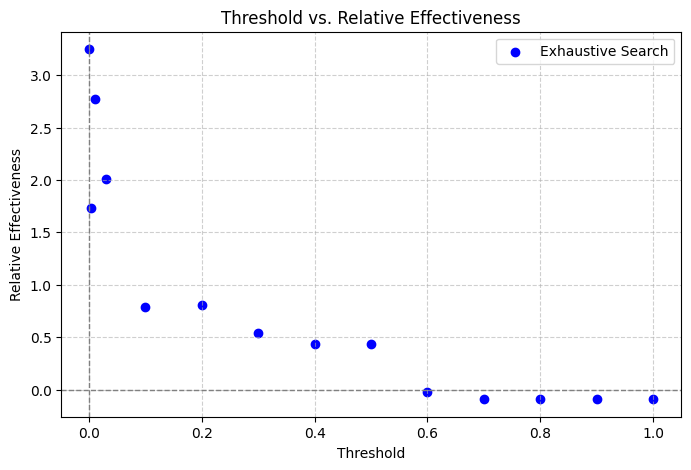

In [42]:
# Re-import necessary libraries since execution state was reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Compute relative effectiveness
accuracy_0 = result_df.at[0, "Source Accuracy"]
identifiability_0 = result_df.at[0, "Threat Accuracy"]

def compute_relative_effectiveness(row):
    numerator = row["Threat Accuracy"] - identifiability_0
    denominator = row["Source Accuracy"] - accuracy_0
    if denominator == 0:
        return np.nan  # Avoid division by zero
    return np.log(numerator / denominator)

result_df["Relative Effectiveness"] = result_df.apply(lambda row: compute_relative_effectiveness(row) if row["Threshold"] > 0 else np.nan, axis=1)

# Extract x (Threshold) and y (Relative Effectiveness) values
x = result_df["Threshold"]
y = result_df["Relative Effectiveness"]

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='blue', marker='o', label="Exhaustive Search")

# Add labels and title
plt.xlabel("Threshold")
plt.ylabel("Relative Effectiveness")
plt.title("Threshold vs. Relative Effectiveness")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Add a horizontal reference line at y=0
plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # Add a vertical reference line at x=0

# Show grid
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


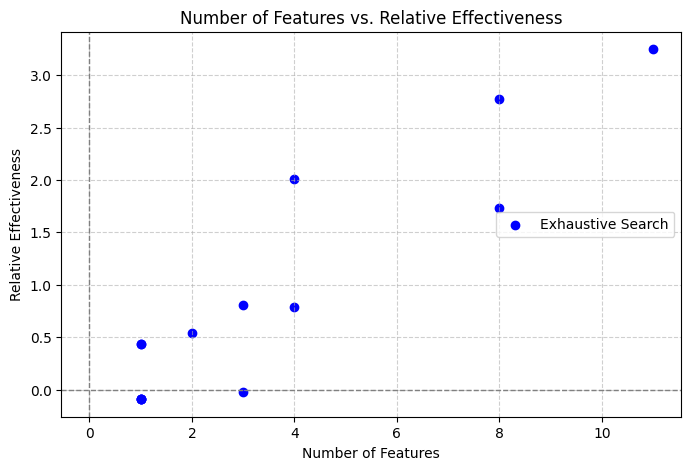

In [40]:
# Re-import necessary libraries since execution state was reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Compute relative effectiveness
accuracy_0 = result_df.at[0, "Source Accuracy"]
identifiability_0 = result_df.at[0, "Threat Accuracy"]

def compute_relative_effectiveness(row):
    numerator = row["Threat Accuracy"] - identifiability_0
    denominator = row["Source Accuracy"] - accuracy_0
    if denominator == 0:
        return np.nan  # Avoid division by zero
    return np.log(numerator / denominator)

result_df["Relative Effectiveness"] = result_df.apply(lambda row: compute_relative_effectiveness(row) if row["Threshold"] > 0 else np.nan, axis=1)

# Extract x (Threshold) and y (Relative Effectiveness) values
x = result_df[f"# Features (Max {max(df['Number of Features'])})"]
y = result_df["Relative Effectiveness"]

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='blue', marker='o', label="Exhaustive Search")

# Add labels and title
plt.xlabel("Number of Features")
plt.ylabel("Relative Effectiveness")
plt.title("Number of Features vs. Relative Effectiveness")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Add a horizontal reference line at y=0
plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # Add a vertical reference line at x=0

# Show grid
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


Source Accuracy Threshold: 0.5921568159726156
Source Accuracy Threshold: 0.5896568159726157
Source Accuracy Threshold: 0.5871568159726156
Source Accuracy Threshold: 0.5821568159726156
Source Accuracy Threshold: 0.5771568159726156
Source Accuracy Threshold: 0.5721568159726156
Source Accuracy Threshold: 0.5671568159726156
Source Accuracy Threshold: 0.5621568159726156


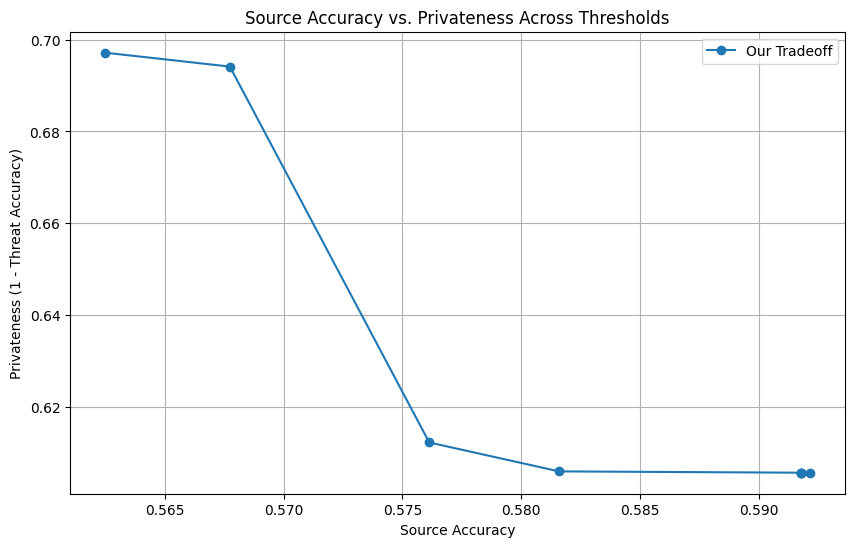

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect results for plotting
plot_data = []

for src_t in src_thres:
    print("Source Accuracy Threshold:", src_t)
    
    # Filter rows based on source accuracy threshold
    filtered_df = df[df['Source Accuracy'] >= src_t]
    
    # Find the lowest threat accuracy
    min_threat_accuracy = filtered_df['Threat Accuracy'].min()
    
    # Filter rows with similar threat accuracy (<1% difference)
    similar_threat_rows = filtered_df[
        (filtered_df['Threat Accuracy'] >= min_threat_accuracy) & 
        (filtered_df['Threat Accuracy'] <= min_threat_accuracy * 1.01)
    ]
    
    # Find the row with the minimum number of features among these rows
    min_feats = similar_threat_rows['Number of Features'].min()
    result = similar_threat_rows[similar_threat_rows['Number of Features'] <= min_feats+1]
    
    # Select the first data point for the current threshold
    if not result.empty:
        first_row = result.iloc[0]
        plot_data.append({
            'Source Accuracy': first_row['Source Accuracy'],
            'Privateness': 1 - first_row['Threat Accuracy'],
            'Threshold': src_t
        })

# Convert collected data to a DataFrame
plot_df = pd.DataFrame(plot_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(plot_df['Privateness'], plot_df['Source Accuracy'], marker='o', label='Our Tradeoff')
    
plt.ylabel('Source Accuracy')
plt.xlabel('Privateness (1 - Threat Accuracy)')
plt.title('Source Accuracy vs. Privateness Across Thresholds')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
for src_t in src_thres:
    print("Source Accuracy Threshold:", src_t)
    min_feats = min(df[df['Source Accuracy']>=src_t]['Number of Features'])
    display(df[(df['Source Accuracy']>=src_t) & (df['Number of Features']==min_feats)].sort_values(by='Threat Accuracy'))

Source Accuracy Threshold: 0.5921568159726156


,Features,Source Accuracy,Threat Accuracy,Number of Features
6655,"[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0.592157,0.394443,11


Source Accuracy Threshold: 0.5896568159726157


,Features,Source Accuracy,Threat Accuracy,Number of Features
6527,"[0, 1, 4, 6, 7, 8, 9, 10, 11, 12]",0.591644,0.394246,10
6399,"[0, 1, 5, 6, 7, 8, 9, 10, 11, 12]",0.591793,0.394437,10


Source Accuracy Threshold: 0.5871568159726156


,Features,Source Accuracy,Threat Accuracy,Number of Features
6527,"[0, 1, 4, 6, 7, 8, 9, 10, 11, 12]",0.591644,0.394246,10
6399,"[0, 1, 5, 6, 7, 8, 9, 10, 11, 12]",0.591793,0.394437,10


Source Accuracy Threshold: 0.5821568159726156


,Features,Source Accuracy,Threat Accuracy,Number of Features
6527,"[0, 1, 4, 6, 7, 8, 9, 10, 11, 12]",0.591644,0.394246,10
6399,"[0, 1, 5, 6, 7, 8, 9, 10, 11, 12]",0.591793,0.394437,10


Source Accuracy Threshold: 0.5771568159726156


,Features,Source Accuracy,Threat Accuracy,Number of Features
6271,"[0, 1, 6, 7, 8, 9, 10, 11, 12]",0.58159,0.394151,9


Source Accuracy Threshold: 0.5721568159726156


,Features,Source Accuracy,Threat Accuracy,Number of Features
7284,"[0, 1, 2, 6, 7, 8, 10]",0.574111,0.456642,7


Source Accuracy Threshold: 0.5671568159726156


,Features,Source Accuracy,Threat Accuracy,Number of Features
7220,"[0, 1, 2, 7, 8, 10]",0.570432,0.455062,6


Source Accuracy Threshold: 0.5621568159726156


,Features,Source Accuracy,Threat Accuracy,Number of Features
7220,"[0, 1, 2, 7, 8, 10]",0.570432,0.455062,6


In [11]:
# Ensemble of threat models (multiple threat models)
# weighted decision based on threat model 1 accuracy, threat model 2 accuracy, number of features
# what evidence do we need to remove feature #2
# use number of features as tie-breaking rule, instead of threat accuracy